In [ ]:
import random
from typing import Iterable

import cirq
import numpy as np
import ucc

from mitiq import zne


def execute(circuit, noise_level=0.05):
    noisy_circuit = cirq.Circuit()
    for op in circuit.all_operations():
        noisy_circuit.append(op)
        if len(op.qubits) == 2:
            noisy_circuit.append(
                cirq.depolarize(p=noise_level, n_qubits=2)(*op.qubits)
            )

    rho = (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix
    )
    return rho[0, 0].real


def get_circuit(depth: int) -> cirq.Circuit:
    num_qubits = 3
    density = 1
    random_circuit = cirq.testing.random_circuit(
        num_qubits,
        depth,
        density,
        gate_domain={
            # cirq.X: 1,
            # cirq.Y: 1,
            # cirq.Z: 1,
            cirq.H: 1,
            cirq.S: 1,
            cirq.T: 1,
            cirq.CNOT: 2,
        },  # TODO: this may not be universal
        # random_state=439,
    )
    return random_circuit


def paired_random_k_local_pauli_string(
    k: int,
    qubits_1: Iterable[cirq.Qid],
    qubits_2: Iterable[cirq.Qid],
) -> tuple[cirq.PauliString, cirq.PauliString]:
    """
    Generate the same random k-local PauliString on two qubit sets, assuming the same ordering.

    Args:
        k: Number of non-identity terms (locality).
        qubits_1: First list of qubits (e.g., from uncompiled circuit).
        qubits_2: Second list of qubits (e.g., from compiled circuit).

    Returns:
        A tuple (pauli_string_1, pauli_string_2) where both have the same Pauli structure
        applied to corresponding qubits from each list.
    """
    qubits_1 = list(qubits_1)
    qubits_2 = list(qubits_2)

    if len(qubits_1) != len(qubits_2):
        raise ValueError(
            "Qubit lists must be the same length and in the same logical order."
        )
    if k > len(qubits_1):
        raise ValueError(
            "k cannot be greater than the number of provided qubits."
        )

    pauli_ops = [cirq.X, cirq.Y, cirq.Z]
    indices = random.sample(range(len(qubits_1)), k)
    random_ops = [random.choice(pauli_ops) for _ in range(k)]

    pauli_dict_1 = {qubits_1[i]: op for i, op in zip(indices, random_ops)}
    pauli_dict_2 = {qubits_2[i]: op for i, op in zip(indices, random_ops)}

    return cirq.PauliString(pauli_dict_1), cirq.PauliString(pauli_dict_2)


import re


def convert_named_to_line_qubits(circuit: cirq.Circuit) -> cirq.Circuit:
    """
    Converts a Cirq circuit with NamedQubits (like q_0, q_1) to LineQubits (0, 1).

    Assumes all NamedQubits are named 'q_<i>' where <i> is an integer.
    """
    # Build a mapping from NamedQubit("q_i") to LineQubit(i)
    qubit_mapping = {}
    for q in circuit.all_qubits():
        if isinstance(q, cirq.NamedQubit):
            match = re.match(r"q_(\d+)", q.name)
            if not match:
                raise ValueError(
                    f"Cannot convert NamedQubit with unexpected name: {q.name}"
                )
            i = int(match.group(1))
            qubit_mapping[q] = cirq.LineQubit(i)

    return circuit.transform_qubits(lambda q: qubit_mapping.get(q, q))


def compute_relative_error(ideal: float, noisy: float) -> float:
    """Compute the relative error between ideal, noisy."""
    return abs(ideal - noisy) / (abs(ideal) + 1e-5)

In [241]:
from functools import partial

data = []

OBSERVABLE_LOCALITY = 2

for depth in range(20, 100, 10):
    num_samples = 0
    # for _ in range(5):
    while num_samples < 10:
        uncompiled = get_circuit(depth)
        ideal = execute(uncompiled, noise_level=0.0)
        if np.isclose(ideal, 0.0):
            continue
        num_samples += 1

        compiled = ucc.compile(uncompiled)  # TODO: use gate set

        uncompiled_unmitigated = execute(uncompiled)
        compiled_unmitigated = execute(compiled)
        uncompiled_mitigated = zne.execute_with_zne(uncompiled, execute)
        compiled_mitigated = zne.execute_with_zne(compiled, execute)

        data.append(
            {
                "depth": depth,
                "compiled_depth": len(compiled_circuit),
                "uncompiled_unmitigated_error": compute_relative_error(
                    ideal, uncompiled_unmitigated
                ),
                "uncompiled_mitigated_error": compute_relative_error(
                    ideal, uncompiled_mitigated
                ),
                "compiled_unmitigated_error": compute_relative_error(
                    ideal, compiled_unmitigated
                ),
                "compiled_mitigated_error": compute_relative_error(
                    ideal, compiled_mitigated
                ),
            }
        )

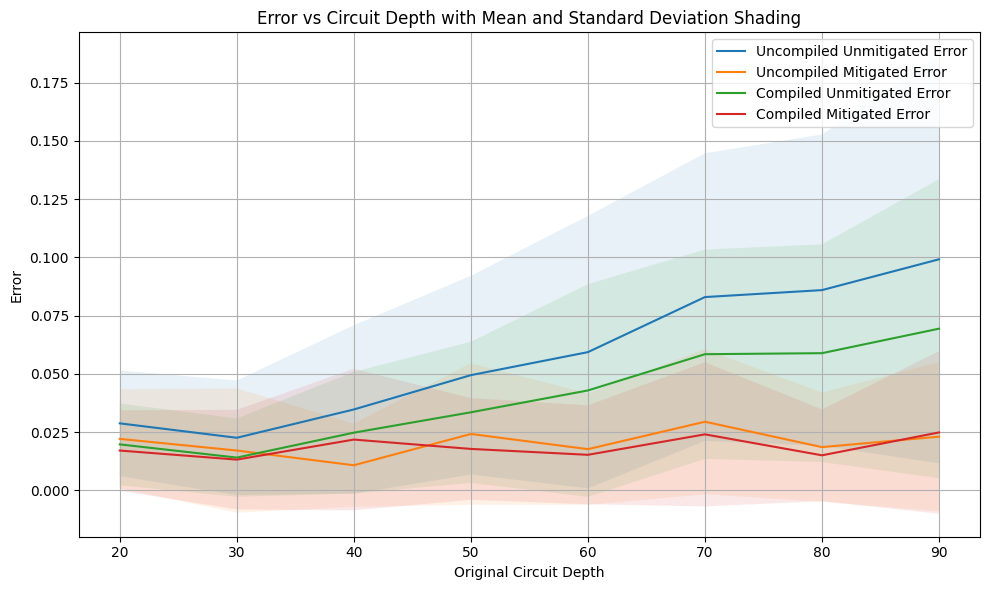

In [242]:
# Ensure the means and stds are numeric arrays for proper math operations
# Recalculate grouped statistics with explicit numeric conversion
grouped = df.groupby("depth").agg(["mean", "std"])
for col in grouped.columns:
    grouped[col] = pd.to_numeric(grouped[col], errors="coerce")

colors = {
    "uncompiled_unmitigated_error": "blue",
    "uncompiled_mitigated_error": "green",
    "compiled_unmitigated_error": "red",
    "compiled_mitigated_error": "purple",
}

# Plot with shaded std dev regions
plt.figure(figsize=(10, 6))

for error in error_types:
    means = grouped[error]["mean"].values.astype(float)
    stds = grouped[error]["std"].values.astype(float)
    depths = grouped.index.values.astype(float)
    # color = colors[error]

    plt.plot(depths, means, label=error.replace("_", " ").title())
    plt.fill_between(depths, means - stds, means + stds, alpha=0.1)

plt.xlabel("Original Circuit Depth")
plt.ylabel("Error")
plt.title("Error vs Circuit Depth with Mean and Standard Deviation Shading")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TODO
# rerun experiment with lower error rate
# run on structured circuits

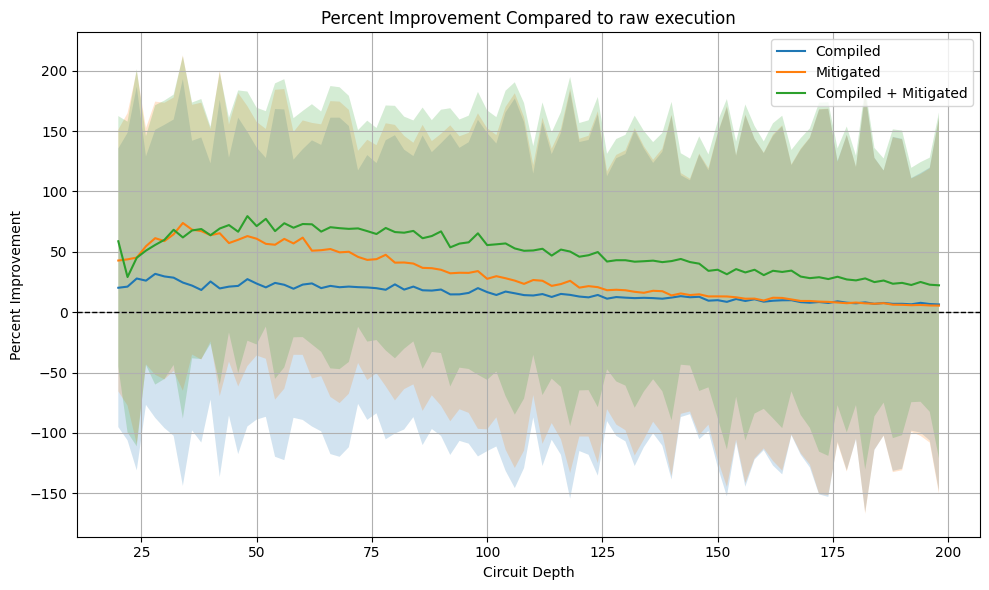

In [ ]:
import numpy as np

# Compute combined standard deviation for the difference (approximation)
# std_diff = sqrt(std_baseline^2 + std_method^2)
percent_improvements_with_std = []

summary = df.groupby("depth").agg(["mean", "std"])
baseline_mean = summary[
    ("uncompiled_unmitigated_error", "mean")
].values.astype(float)
baseline_std = summary[("uncompiled_unmitigated_error", "std")].values.astype(
    float
)

method_order = [
    "uncompiled_unmitigated_error",  # baseline
    "compiled_unmitigated_error",
    "uncompiled_mitigated_error",
    "compiled_mitigated_error",
]


for method in method_order[1:]:
    method_mean = summary[(method, "mean")].values.astype(float)
    method_std = summary[(method, "std")].values.astype(float)

    improvement = 100 * (baseline_mean - method_mean) / baseline_mean
    std_improvement = 100 * np.sqrt(
        (baseline_std / baseline_mean) ** 2 + (method_std / baseline_mean) ** 2
    )

    percent_improvements_with_std.append(
        (method, improvement, std_improvement)
    )

# Plot with properly computed std deviations
plt.figure(figsize=(10, 6))

depths = summary.index.values.astype(float)

legend = {
    "uncompiled_unmitigated_error": "Baseline",
    "compiled_unmitigated_error": "Compiled",
    "uncompiled_mitigated_error": "Mitigated",
    "compiled_mitigated_error": "Compiled + Mitigated",
}

for method, improvement, std in percent_improvements_with_std:
    label = legend[method]

    plt.plot(depths, improvement, label=label)
    plt.fill_between(depths, improvement - std, improvement + std, alpha=0.2)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Circuit Depth")
plt.ylabel("Percent Improvement")
plt.title("Percent Improvement Compared to raw execution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# where does "ideal" go on this plot?
# how close are these techniques to ideal?

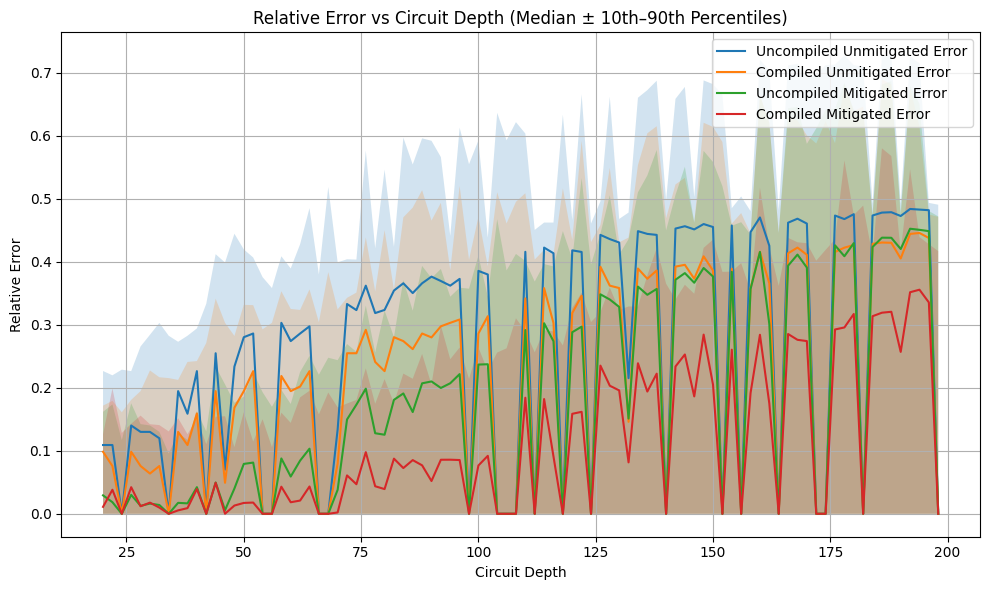

In [157]:
df = pd.DataFrame(data)

# Step 2: Define the columns that hold error values
error_columns = [
    "uncompiled_unmitigated_error",
    "compiled_unmitigated_error",
    "uncompiled_mitigated_error",
    "compiled_mitigated_error",
]


# Step 3: Define aggregation for median, 10th, and 90th percentiles
def build_flat_agg(col):
    return {
        f"{col}_median": (col, "median"),
        f"{col}_p10": (col, lambda x: np.percentile(x, 10)),
        f"{col}_p90": (col, lambda x: np.percentile(x, 90)),
    }


agg_dict = {}
for col in error_columns:
    agg_dict.update(build_flat_agg(col))

# Step 4: Group by depth and aggregate with flat column names
grouped = df.groupby("depth").agg(**agg_dict)

# Step 5: Plot median + 10th–90th percentile shaded bands
plt.figure(figsize=(10, 6))

for col in error_columns:
    median = grouped[f"{col}_median"].astype(float).values
    p10 = grouped[f"{col}_p10"].astype(float).values
    p90 = grouped[f"{col}_p90"].astype(float).values
    depths = grouped.index.values.astype(float)

    plt.plot(depths, median, label=col.replace("_", " ").title())
    plt.fill_between(depths, p10, p90, alpha=0.2)

plt.xlabel("Circuit Depth")
plt.ylabel("Relative Error")
plt.title("Relative Error vs Circuit Depth (Median ± 10th–90th Percentiles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [244]:
test = get_circuit(10)
print(test)

              ┌──┐
0: ───X───H─────X────────────S───T───────X───────
      │         │                        │
1: ───@────────S┼────@───S───S───────X───┼───S───
                │    │               │   │
2: ───────H─────@────X───H───────H───@───@───S───
              └──┘


In [245]:
ucc.compile(test)

q_0: ───Ry(-0.5π)────Rz(-0.255π)───@───────────Rz(-0.745π)───Ry(0.5π)──────Rz(-0.661π)───@───Rz(-0.339π)───Ry(0.5π)──────Rz(-0.25π)────Ry(-0.5π)────Rz(0.25π)────────────────────────────────────────────────────────────────────────────────────────────────────@───Rz(-0.25π)───Ry(0.5π)─────
                                   │                                                     │                                                                                                                                                                       │
q_1: ───Rz(0.032π)───Ry(0.5π)──────X───────────Ry(-0.5π)─────Rz(-0.532π)───Rz(-0.5π)─────┼──────────────────────────────────────────────────────────────────────@───Rz(0.5π)──────Ry(0.5π)──────────────────@───Ry(0.5π)───Rz(0.835π)────────────────────────────┼─────────────────────────────
                                                                                         │                                                                      │                                           │                                                    │
q_2: ───Rz(0.5π)─────Ry(0.489π)────Rz(-0.5π)─────────────────────────────────────────────X───Ry(-0.5π)─────Rz(-0.489π)───Rz(-0.835π)───Ry(0.532π)───Rz(-0.5π)───X───Rz(-0.997π)───Ry(0.468π)───Rz(0.468π)───X───Ry(0.5π)───Rz(-0.968π)───Rz(0.032π)───Ry(0.5π)───X───Ry(-0.5π)────Rz(0.468π)───